# B-SOSE preliminary

This notebook contains some early drafts and examples of interacting with a future BSOSE index on Argovis. None of the features or schema below are in production, and all may change before release.

In [1]:
import requests, copy, os, sys, pandas, xarray, datetime
sys.path.append(os.path.abspath(os.pardir)+'/dataset_specific_notebooks')
import helpers
from argovisHelpers import helpers as avh
import matplotlib.pyplot as plt

API_ROOT="http://seas.ucsd.edu:8080"

Start by grabbing some BSOSE data. It is timeseries formatted, each data document corresponding to a specific lat / long / depth triple, with metadata unique to this coordinate included on the data doc.

In [2]:
#region = '[[-52.506902182605074,-78.36870057014637],[-30.874884098703156,-78.47461560716616],[-25.950522258465295,-75.69377519912418],[-58.83822454862517,-75.60658287757781],[-52.506902182605074,-78.36870057014637]]'
region = '[[-40,-75],[-40,-74],[-39,-74],[-39,-75],[-40,-75]]'
qs = {
    "polygon": region,
    "data": 'THETA,SALT'
}

bsose = requests.get(API_ROOT+"/timeseries/bsose", params=qs).json()

In [3]:
bsose[0]

{'_id': '-39.083_-74.063_-2.100',
 'metadata': ['-39.083_-74.063'],
 'basin': 10.0,
 'geolocation': {'type': 'Point',
  'coordinates': [-39.08331298828125, -74.0633544921875]},
 'level': 2.0999999046325684,
 'cell_vertical_fraction': 1.0,
 'sea_binary_mask_at_t_locaiton': True,
 'cell_z_size': 4.199999809265137,
 'reference_density_profile': 1020.963134765625,
 'data': [[-1.568336009979248,
   -1.5341726541519165,
   -1.4557316303253174,
   -1.3287993669509888,
   -1.222676396369934,
   -1.1326563358306885,
   -1.0937778949737549,
   -0.672788143157959,
   -0.3507422208786011,
   -0.3544083535671234,
   -0.5832356810569763,
   -0.7007371187210083,
   -0.949131965637207,
   -1.1094847917556763,
   -1.1578925848007202,
   -1.3210370540618896,
   -1.3837645053863525,
   -1.4661051034927368,
   -1.4988640546798706,
   -1.546426773071289,
   -1.559950828552246,
   -1.572356104850769,
   -1.5806465148925781,
   -1.61391282081604,
   -1.674829125404358,
   -1.6918492317199707,
   -1.691989541

We can grab the corresponding metadata, one metadata doc for each lat/long point:

In [4]:
qs_meta = copy.deepcopy(qs)
qs_meta['batchmeta'] = True
bsose_meta = requests.get(API_ROOT+"/timeseries/bsose", params=qs_meta).json()
bsose_meta[0]

{'_id': '-39.083_-74.018',
 'latitude': -74.01753234863281,
 'longitude': -39.08331298828125,
 'data_type': 'BSOSE-profile',
 'date_updated_argovis': {'$date': {'$numberLong': '1749759150820'}},
 'timeseries': [{'$date': {'$numberLong': '1357344000000'}},
  {'$date': {'$numberLong': '1357776000000'}},
  {'$date': {'$numberLong': '1358208000000'}},
  {'$date': {'$numberLong': '1358640000000'}},
  {'$date': {'$numberLong': '1359072000000'}},
  {'$date': {'$numberLong': '1359504000000'}},
  {'$date': {'$numberLong': '1359936000000'}},
  {'$date': {'$numberLong': '1360368000000'}},
  {'$date': {'$numberLong': '1360800000000'}},
  {'$date': {'$numberLong': '1361232000000'}},
  {'$date': {'$numberLong': '1361664000000'}},
  {'$date': {'$numberLong': '1362096000000'}},
  {'$date': {'$numberLong': '1362528000000'}},
  {'$date': {'$numberLong': '1362960000000'}},
  {'$date': {'$numberLong': '1363392000000'}},
  {'$date': {'$numberLong': '1363824000000'}},
  {'$date': {'$numberLong': '1364256000

From here it is a trivial matter to turn Argovis data into pandas data frames and xarray data sets, and leverage all the built in slicing and plotting those tools offer:

In [5]:
df = helpers.level_df(bsose, 
                      ['THETA', 'SALT', 'longitude', 'latitude', 'level'], 
                      timesteps=bsose_meta[0]['timeseries'], 
                      index=["latitude","longitude","timestamp","level"]
                     )
ds = df.to_xarray()

In [6]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 23, longitude: 6, timestamp: 876, level: 36)
Coordinates:
  * latitude   (latitude) float64 -75.0 -74.95 -74.91 ... -74.11 -74.06 -74.02
  * longitude  (longitude) float64 -39.92 -39.75 -39.58 -39.42 -39.25 -39.08
  * timestamp  (timestamp) datetime64[ns] 2013-01-05 2013-01-10 ... 2024-12-28
  * level      (level) float64 2.1 6.7 12.15 18.55 ... 700.0 800.0 900.0 1e+03
Data variables:
    THETA      (latitude, longitude, timestamp, level) float64 -1.706 ... -1.31
    SALT       (latitude, longitude, timestamp, level) float64 33.96 ... 34.51

Let's start by plotting a simple map of both our variables for a single timestamp and level:

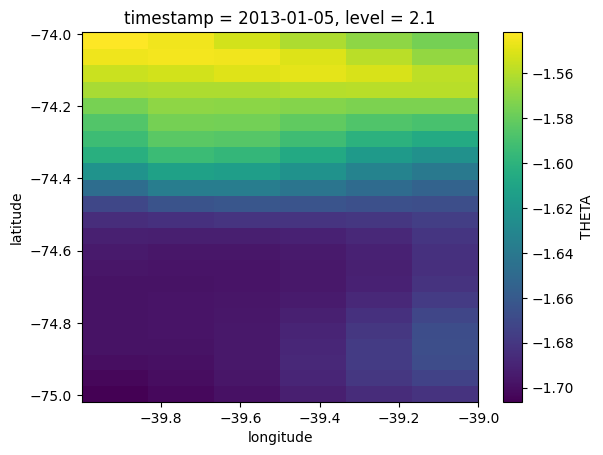

In [7]:
simplemap = ds.loc[{"timestamp":avh.parsetime('2013-01-05T00:00:00.000Z'), "level":ds['level'][0]}]
simplemap['THETA'].plot()

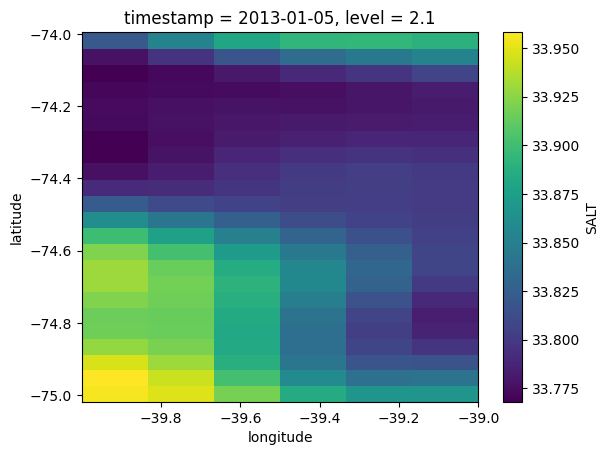

In [8]:
simplemap['SALT'].plot()

We can also do timeseries for a specific geospatial point, to reveal seasonal cycles:

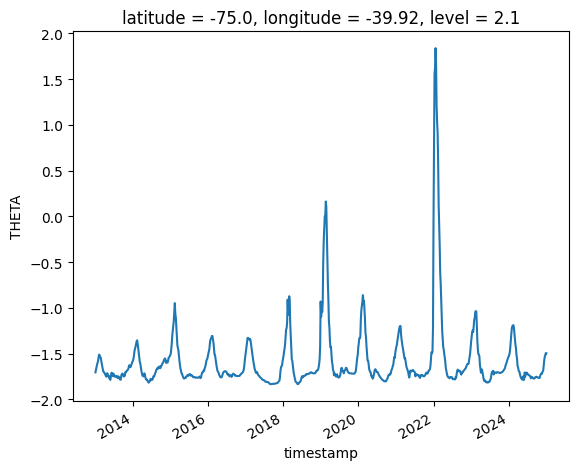

In [9]:
simple_ts = ds.loc[{"longitude": ds['longitude'][0], "latitude": ds['latitude'][0], "level": ds['level'][0]}]
simple_ts['THETA'].plot()

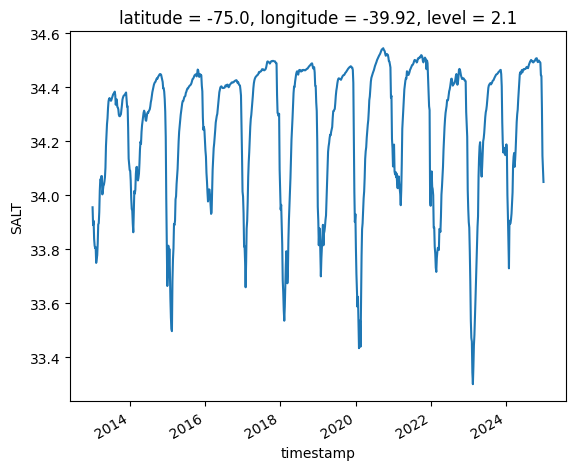

In [10]:
simple_ts['SALT'].plot()

Profiles at a given lat / long / timestep triple are constructed similarly:

In [11]:
simple_profile = ds.loc[{"longitude": ds['longitude'][0], "latitude": ds['latitude'][0], "timestamp": ds['timestamp'][0]}]

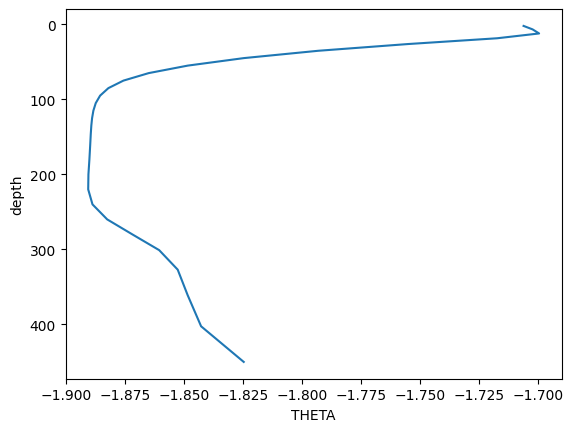

In [12]:
var = 'THETA'
plt.plot(simple_profile[var], simple_profile['level'])
plt.gca().invert_yaxis()
plt.xlabel(var)
plt.ylabel('depth')
plt.show()

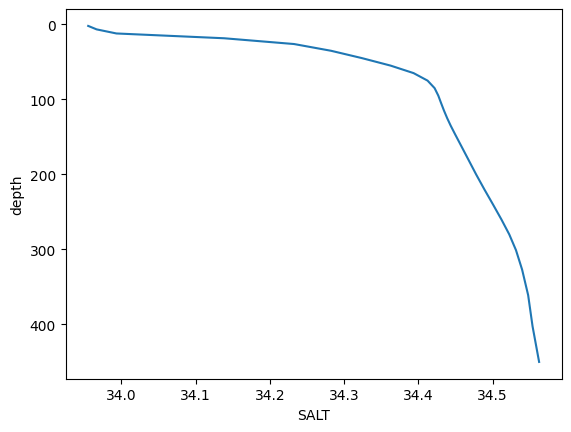

In [13]:
var = 'SALT'
plt.plot(simple_profile[var], simple_profile['level'])
plt.gca().invert_yaxis()
plt.xlabel(var)
plt.ylabel('depth')
plt.show()

BSOSE reports model cell areas at each latitude / longitude point. We can use these cell areas to construct area weighted means, including meridional and zonal means:

In [14]:
weight_table = [{'weight': x['cell_area'], 'longitude': x['longitude'], 'latitude': x['latitude']} for x in bsose_meta]
weight_df = pandas.DataFrame(weight_table)
weight_ds = xarray.Dataset.from_dataframe(weight_df.set_index(["latitude", "longitude"]))
weighted_ds = ds.weighted(weight_ds["weight"])

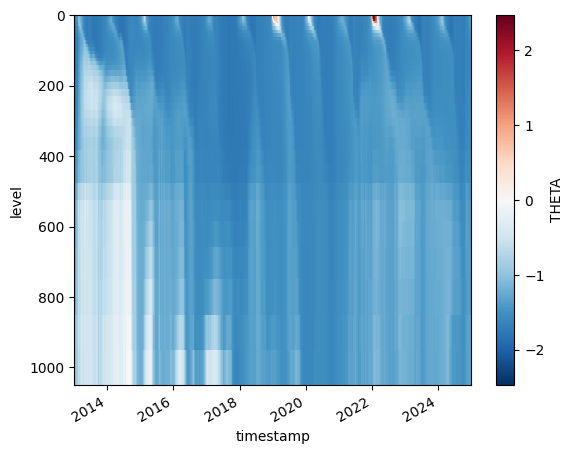

In [15]:
awm = weighted_ds.mean(("longitude", "latitude"))
awm['THETA'].plot(y="level",yincrease=False)

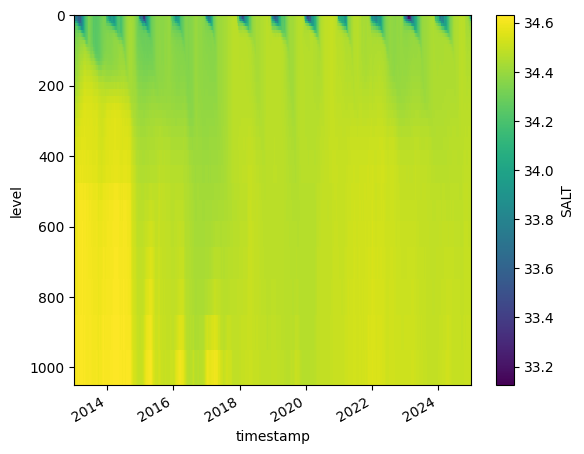

In [16]:
awm['SALT'].plot(y="level",yincrease=False)

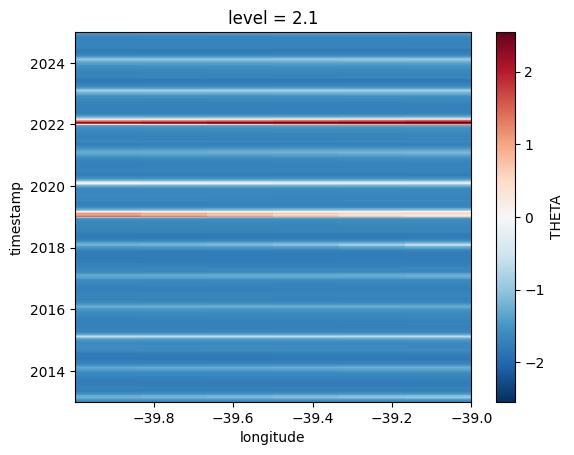

In [17]:
meridional = weighted_ds.mean(("latitude")).loc[{"level":ds['level'][0]}]
meridional['THETA'].plot(y='timestamp')

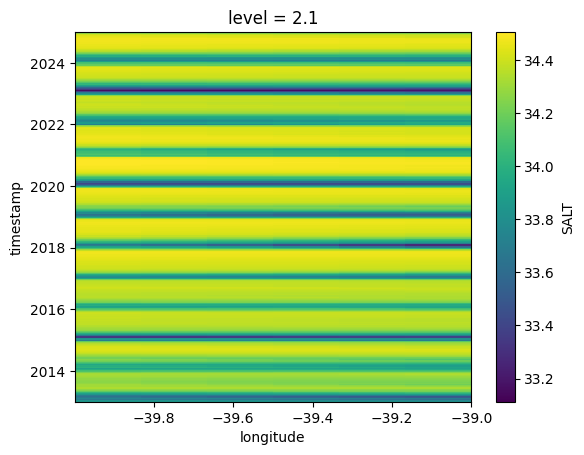

In [18]:
meridional['SALT'].plot(y='timestamp')

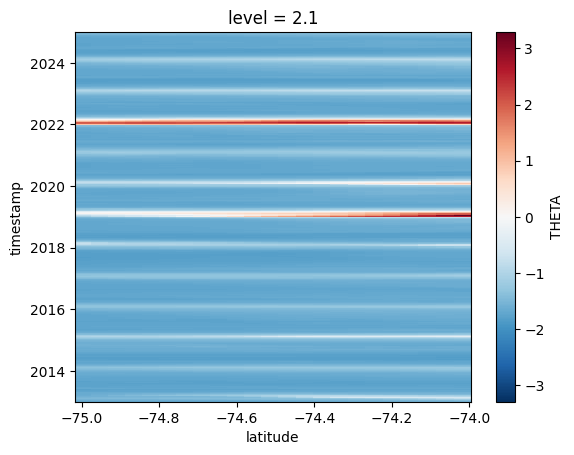

In [19]:
zonal = weighted_ds.mean(("longitude")).loc[{"level":ds['level'][0]}]
zonal['THETA'].plot(y='timestamp')

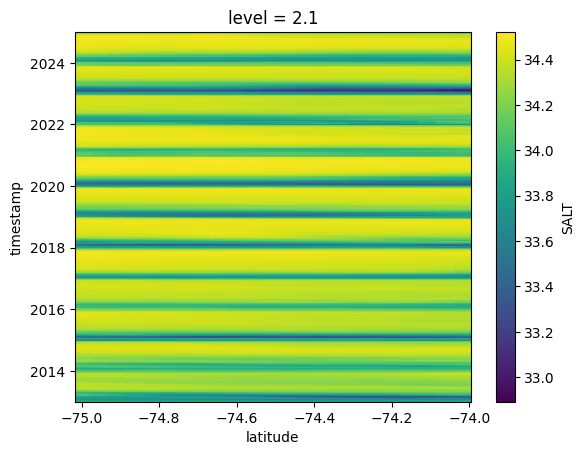

In [20]:
zonal['SALT'].plot(y='timestamp')